In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import math
from collections import Counter
import random
import heapq
import operator

In [139]:
# Part A.1
def clean_csv(file):
    """
    Clean csv file to get n (200) most common words
    used across all sentences.
    
    file: name of csv file
    return: dataframe, and list of n (200)
    """ 
    # read csv
    df = pd.read_csv(file)

    # remove punctuation from text column
    df['text'] = df['text'].str.replace(r'[^\w\s]+', '', regex=True)

    # convert text column to lower case
    df['text'] = df['text'].map(str.lower)

    # text column without stop words
    df['no_stop_words'] = ''

    # load stop words from file
    with open('NLTK_English_stopwords.txt', 'r') as f:
        stop_words = f.read().split()

    # iterate through each row in df to remove stop words
    # and add into a new column
    for i, row in df.iterrows():
        # Tokenize the text
        tokens = nltk.word_tokenize(row['text'])

        # Remove stop words from the tokens and join back into a string
        filtered_tokens = [word for word in tokens if word not in stop_words]
        filtered_text = ' '.join(filtered_tokens)

        # Replace the original text with the filtered text in the DataFrame
        df.at[i, 'no_stop_words'] = filtered_text

    # top 100 most common words
    # all the text (without stopwords)
    all_text = ''.join(df['no_stop_words'])
    tokens = nltk.word_tokenize(all_text)
    word_counts = Counter(tokens)

    # word count of most common n words
    most_common_wc = word_counts.most_common(350)

    # list of n most common words
    most_common = [word for word, count in most_common_wc]
    return df, most_common

In [140]:
df, most_common = clean_csv('statements.csv')
df.head()

,id,speaker,text,no_stop_words
0,0,obama,during the recession marvins competitors close...,recession marvins competitors closed dozens pl...
1,1,obama,and we will rise or fall on that journey as on...,rise fall journey nation
2,2,obama,my my differences with him my differences wi...,differences differences personal
3,3,obama,thats why weve excluded lobbyists from policym...,thats weve excluded lobbyists policymaking job...
4,4,obama,i recognize that many still have a strong desi...,recognize many still strong desire focus past


In [141]:
# Part A.2
# table report
def table_metrics(word_list):
    """
    For each word in list of selected words, create a table reporting: 
    ◦ word 
    ◦ number of occurrences of the word 
    ◦ number of occurrences of the word in sentences spoken by Obama 
    ◦ number of occurrences of the words in sentences spoken by Trump 
    ◦ Phi Coefficient for each word
    
    word_list: list of selected words
    return: dataframe
    """
    
    # initialize table dictionary
    table = pd.DataFrame(columns=['Word',
                                  'Total Occurrences', 
                                  'Obama Occurrences', 
                                  'Trump Occurrences', 
                                  'Phi Coefficient'])

    # for every word in list of most common words
    for word in word_list:
        # Count occurrences of the word across the dataframe
        total_count = sum(df['text'].str.count(word))
    
        # Count occurrences of the word in Obama sentences
        obama_word = sum(df[df['speaker'] == 'obama']['text'].str.count(word))
    
        # Count occurrences of the word in Trump sentences
        trump_word = sum(df[df['speaker'] == 'trump']['text'].str.count(word))
    
        # Total number of Obama sentences
        obama_num_sent = len(df[df['speaker'] == 'obama'])
    
        # Total number of Trump sentences
        trump_num_sent = len(df[df['speaker'] == 'trump'])
    
        # Total number of Obama sentences without the word
        obama_not_word = trump_num_sent - obama_word
    
        # Total number of Trump sentences without the word
        trump_not_word = obama_num_sent - trump_word

        # Total number of sentences with no occurrences
        total_not_word = obama_not_word + trump_not_word
    
        # Total number of sentences with occurrences
        total_with_word = obama_word + trump_word

        # Calculate Phi Coefficient for the word
        phi_numerator = obama_not_word*trump_word - trump_not_word*obama_word
        phi_denominator = math.sqrt(total_not_word*total_with_word*obama_num_sent*trump_num_sent)
        phi_coeff = phi_numerator/phi_denominator

        # makes a new row for each word to concat onto df
        new_row = pd.DataFrame({'Word': word, 
                                'Total Occurrences': total_count, 
                                'Obama Occurrences': obama_word, 
                                'Trump Occurrences': trump_word,
                                'Phi Coefficient': phi_coeff}, index=[0])
        table = pd.concat([table, new_row], ignore_index=True)
    
    # sort table of words from most to least frequent
    table = table.sort_values('Total Occurrences', ascending=False)
    return table

In [142]:
table = table_metrics(most_common)
table.head(10)

,Word,Total Occurrences,Obama Occurrences,Trump Occurrences,Phi Coefficient
243,ill,196,103,93,-0.025191
42,ever,87,43,44,0.003548
19,america,66,42,24,-0.072498
162,end,59,32,27,-0.021220
153,thing,58,9,49,0.171128
3,want,55,20,35,0.065795
14,every,49,26,23,-0.013897
141,act,49,22,27,0.023162
22,see,48,24,24,0.000000
1,country,48,19,29,0.046780


In [143]:
# Part A.2
"""
Find the 10 words most closely correlated with
Trump and Obama
"""
# Sort the table by phi coefficients
sorted_by_phi = table.sort_values('Phi Coefficient', ascending=False)

# Get the 10 words with highest phi coefficients for Trump
trump_words = sorted_by_phi[sorted_by_phi['Trump Occurrences']>0].head(10)['Word'].tolist()

# Get the 10 words with lowest phi coefficients for Obama
obama_words = sorted_by_phi[sorted_by_phi['Obama Occurrences']>0].tail(10)['Word'].tolist()

print("Top 10 words closely correlated with Trump:", trump_words)
print("Top 10 words closely correlated with Obama:", obama_words)

Top 10 words closely correlated with Trump: ['thing', 'think', 'big', 'look', 'love', 'guy', 'great', 'theyre', 'really', 'way']
Top 10 words closely correlated with Obama: ['across', 'thank', 'work', 'years', 'government', 'must', 'today', 'health', 'year', 'war']


In [144]:
# Part B.1
"""
Implementing Naive Bayes to predict speaker for
each sentence using log probabilities.
Trump=1
Obama=0
"""
# create lists of all trump sentences and all obama sentences
trump_sents = df[df['speaker'] == 'trump']['no_stop_words'].tolist()
obama_sents = df[df['speaker'] == 'obama']['no_stop_words'].tolist()

# Initialize a set of all unique words
unique_words = set()

# for each sentence in the entire dataset:
for sentence in trump_sents + obama_sents:
    
    # for each work in the splitted sentence:
    for word in sentence.split():
        
        # add the word to the set list
        unique_words.add(word)

# Initialize dictionaries to store the count of each word per speaker
trump_wc_dict = {word: 0 for word in unique_words}
obama_wc_dict = {word: 0 for word in unique_words}

# for each trump sentence:
# split the sentence into words:
# count the occurrences of each word and add to dict
for sentence in trump_sents:
    for word in sentence.split():
        trump_wc_dict[word] += 1

# for each obama sentence:
# split the sentence into words:
# count the occurrences of each word and add to dict
for sentence in obama_sents:
    for word in sentence.split():
        obama_wc_dict[word] += 1

        
def log_probability(sentence):
    """
    calculates the log probability of a sentence
    being spoken by each speaker. If Trump's log
    probability is > Obama's, function appends 1 to
    predictions (Trump), else 0 (Obama)
    
    sentence: string
    return: log probability of Obama or Trump
    saying the sentence
    """
    # Initialize the log probabilities
    log_prob_trump = 0
    log_prob_obama = 0
    
    # Split the sentence into words
    words = sentence.split()
    
    # for each word:
    # if the word is a new word (aka not seen in dict):
    # set its count = 1 to avoid probability = 0
    for word in words:
        if word not in trump_wc_dict:
            trump_wc_dict[word] = 1
        if word not in obama_wc_dict:
            obama_wc_dict[word] = 1
        
        # Calculate log probability of the word given each speaker
        prob_if_trump = math.log((trump_wc_dict[word] + 1) / (sum(trump_wc_dict.values()) + len(unique_words)))
        prob_if_obama = math.log((obama_wc_dict[word] + 1) / (sum(obama_wc_dict.values()) + len(unique_words)))
        
        # Add log probability of the word to the running totals
        log_prob_trump += prob_if_trump
        log_prob_obama += prob_if_obama
    
    return log_prob_trump, log_prob_obama

def naive_bayes(df):
    """
    implement naive bayes
    
    df: dataframe
    return: new dataframe with naive bayes pred
    column 
    """
    # initialize list of predictions
    predictions = []

    # for each sentence in dataset:
    # get the log probability of trump or obama saying it
    # any instance when trump's probability is > Obama's:
    # append 1, else 0
    for sentence in df['no_stop_words']:
        log_prob_trump, log_prob_obama = log_probability(sentence)
        if log_prob_trump > log_prob_obama:
            predictions.append(1)
        else:
            predictions.append(0)

    # Add the predictions to the dataframe
    df['naive_bayes_pred_speaker'] = predictions
    return df

In [145]:
df = naive_bayes(df)
df

,id,speaker,text,no_stop_words,naive_bayes_pred_speaker
0,0,obama,during the recession marvins competitors close...,recession marvins competitors closed dozens pl...,0
1,1,obama,and we will rise or fall on that journey as on...,rise fall journey nation,0
2,2,obama,my my differences with him my differences wi...,differences differences personal,0
3,3,obama,thats why weve excluded lobbyists from policym...,thats weve excluded lobbyists policymaking job...,0
4,4,obama,i recognize that many still have a strong desi...,recognize many still strong desire focus past,0
...,...,...,...,...,...
995,995,trump,i would like to ask now that we all observe a ...,would ask observe moment silence victims attack,1
996,996,trump,if i dont give the answer im not going to win ...,dont give answer win write incredibly negatively,1
997,997,trump,but after what you said about me how can you p...,possibly join team mr,1
998,998,trump,we wanted to get it out really really quickly ...,wanted really really quickly pertain whats right,1


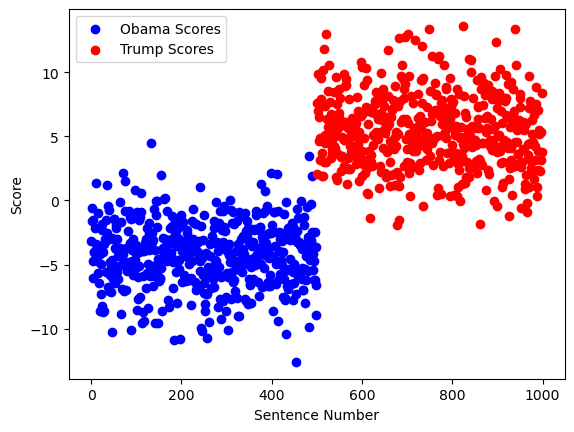

In [146]:
# Part B.2
"""
scatter plot showing the log probability score
differences for all 1,000 sentences to see how
well the model predicts Obama and Trump sentences.
"""

# initialize score differences
score_diffs = []

for i, sentence in enumerate(df['no_stop_words']):
    # Calculate the score difference for each sentence
    trump_score = log_probability(sentence)[0]
    obama_score = log_probability(sentence)[1]
    score = trump_score - obama_score
    score_diffs.append(score)
    
trump_scores = score_diffs[500:]
obama_scores = score_diffs[:500]


plt.scatter(range(500), score_diffs[:500], c='blue', label='Obama Scores')
plt.scatter(range(500, 1000), score_diffs[500:], c='red', label='Trump Scores')
#plt.scatter(range(1000), score_diffs, c=['b']*500 + ['r']*500)
plt.xlabel('Sentence Number')
plt.ylabel('Score')
plt.legend()
plt.show()

In [147]:
# Part C.1
"""
Selecting a subset of words for kNN learning by
getting 100 words with the highest phi coefficients for
Trump and Obama (50 each)
"""
# Get the 50 words with highest phi coefficients for Trump
trump_50 = sorted_by_phi[sorted_by_phi['Trump Occurrences']>0].head(50)['Word'].tolist()

# Get the 50 words with lowest phi coefficients for Obama
obama_50 = sorted_by_phi[sorted_by_phi['Obama Occurrences']>0].tail(50)['Word'].tolist()

# concat into one large list
subset_knn = trump_50 + obama_50

In [148]:
# Part C.2
"""
vectorize df sentences and calculate cosine
similarity
"""

def vectorize_sent(df, subset):
    """
    vectorize each sentence of a dataframe
    column into zeroes and ones indicating
    if each word of a sentence is contained
    in the given subset of words
    
    df: dataframe
    subset: subset of words
    return: array
    """
    sent_vectors = []

    # loop over each sentence to convert to vectorize it
    #def vectorize(sentence, features):
    for sentence in df['no_stop_words']: 
    
        # initialize vector
        vector = [0] * len(subset)
    
        for i, word in enumerate(subset):
            if word in sentence:
                vector[i] += 1
        # append vector
        sent_vectors.append(vector)
    return np.array(sent_vectors)


def cosine_similarity(vec1, vec2):
    """
    Calculates cosine similarity between 
    two vectors
    
    vec1: vector
    vec2: vector
    return: cosine similarity value
    """
    
    # dot product of vectors
    dot_prod = np.dot(vec1, vec2)
    
    # Euclidean length of vector 1 and 2
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    # check for division by zero
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    # add a small epsilon value for cases of divsion by zero
    return dot_prod / ((norm1 + 1e-8) * (norm2 + 1e-8))


def sim_matrix (A, x):
    """
    compute similarity matrix 
    A: array of instance attributes
    x: (cosine) similarity measure
    return: matrix
    """
    m = A.shape[0]
    M = np.zeros(shape=(m,m))
    for i in range(m):
        for j in range(m):
            M[i,j] = x(A[i,], A[j])
    return M

In [149]:
# compute similarity matrix using cosine similarity
A = vectorize_sent(df, subset_knn)
sim_matrix = sim_matrix(A, cosine_similarity)
print(sim_matrix)

[[0.99999998 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.99999998 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999998]]


In [150]:
# Part C.2
def predict_row (row, k):
    """
    make a given a row of values, which represents
    the scores of all sentence distances in relation to one specific sentence
    use k nearest neighbors to make a prediction
    row: row of score values
    
    k: k value
    return: int
    """
    list_pred = zip(*heapq.nlargest(k+1, enumerate(row), key=operator.itemgetter(1)))
    scores = list(list_pred)[0][1:]
    
    rand_subset = rand_df[rand_df.index.isin(scores)]
    sumObama = rand_subset.loc[rand_subset['speaker'] == 'obama'].shape[0]
    sumTrump = rand_subset.loc[rand_subset['speaker'] == 'trump'].shape[0]
    
    guess = 1 if sumTrump > sumObama else 0
    return 1 if sumTrump > sumObama else 0


def kNN(df, k, M):
    """
    calculate kNN
    
    df: dataframe
    k: k value
    M: similarity matrix using cosine similarity
    return: dataframe
    """
    output = df.index.map(lambda x:makeOnePrediction(M[x], k))
    pred_df = pd.DataFrame({'knn_pred_speaker': output}, index=df.index)
    return pd.concat([df, pred_df], axis=1)

In [151]:
rand_df = df.sample(frac=1)
rand_df_5 = kNN(rand_df, 5, sim_matrix)
rand_df_5.head(10)

,id,speaker,text,no_stop_words,naive_bayes_pred_speaker,knn_pred_speaker
913,913,trump,it is a strike at the heart and soul of who we...,strike heart soul nation,1,0
841,841,trump,the last thing we need is hillary clinton in t...,last thing need hillary clinton white house ex...,1,1
466,466,obama,it has not met its obligations and it rejects ...,met obligations rejects offers would provide p...,0,0
321,321,obama,its a plan to reward small businesses and manu...,plan reward small businesses manufacturers cre...,0,0
416,416,obama,we have to do that work but its important that...,work important acknowledge facts,0,0
77,77,obama,violence has been reduced substantially from t...,violence reduced substantially horrific sectar...,0,0
766,766,trump,but if i get in there its going to change and ...,change change quickly,1,0
518,518,trump,as soon as she arrived she found that pretty s...,soon arrived found pretty snake shed taken rev...,1,0
485,485,obama,it results in an economy that invests too litt...,results economy invests little future,0,0
616,616,trump,theyve got terror cells everywhere including i...,theyve got terror cells everywhere including w...,1,1


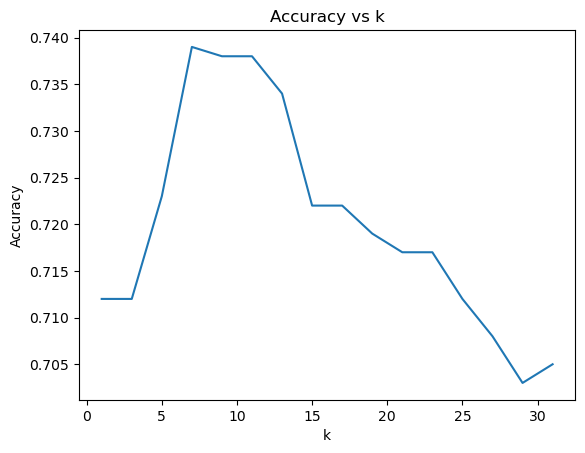

In [152]:
# Part C.3
"""
Plot accuracy of kNN model as a function of k over 
range 1-31
"""
def accuracy_score(predictions, df):
    """
    Compute the accuracy score of the kNN model's predictions with respect to the actual labels in the original dataframe.
    
    predictions: array of predicted values from kNN() function
    df: original dataframe with true labels
    return: the accuracy score (percentage of correctly predicted labels)
    """
    correct_predictions = np.sum(predictions == df['speaker'].map(lambda x: 1 if x == 'trump' else 0))
    total_predictions = len(predictions)
    accuracy = correct_predictions / total_predictions
    return accuracy

# list of k for graph
ks = list(filter(lambda x: x % 2 == 1, range(1, 32)))

# accuracies
accuracies = []
# Iterate over the values of k and compute the accuracy score for each value of k
for k in ks:
    knn_pred = kNN(rand_df, k, sim_matrix)
    accuracy = accuracy_score(knn_pred['knn_pred_speaker'], rand_df)
    
    # Append the accuracy score to the accuracies list
    accuracies.append(accuracy)

# Plot the accuracies against the list of values of k
plt.plot(ks, accuracies)
plt.title('Accuracy vs k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

In [153]:
# metrics for spreadsheet
def classification_metrics(predictions, df):
    """
    Compute the classification metrics of the predictions of a
    df.
    
    predictions: array of predicted values from kNN() function
    df: original dataframe with true labels
    
    Returns a dictionary containing the following classification metrics:
    - Accuracy
    - Sensitivity
    - Specificity
    - Precision
    - F1-Score
    """
    tp = np.sum((predictions == 1) & (df['speaker'] == 'trump'))
    tn = np.sum((predictions == 0) & (df['speaker'] == 'obama'))
    fp = np.sum((predictions == 1) & (df['speaker'] == 'obama'))
    fn = np.sum((predictions == 0) & (df['speaker'] == 'trump'))
    
    accuracy = (tp + tn) / len(predictions)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    metrics = {'Accuracy': accuracy, 
               'Sensitivity': sensitivity, 
               'Specificity': specificity, 
               'Precision': precision, 
               'F1-Score': f1_score}
    
    return metrics

In [154]:
# metrics for Naive Bayes
classification_metrics(rand_df['naive_bayes_pred_speaker'], rand_df)

{'Accuracy': 0.97,
 'Sensitivity': 0.976,
 'Specificity': 0.964,
 'Precision': 0.9644268774703557,
 'F1-Score': 0.970178926441352}

In [155]:
# metrics for kNN
classification_metrics(rand_df_5['knn_pred_speaker'], rand_df_5)

{'Accuracy': 0.723,
 'Sensitivity': 0.514,
 'Specificity': 0.932,
 'Precision': 0.8831615120274914,
 'F1-Score': 0.649810366624526}